In [11]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle

from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [21]:
foldernames = os.listdir('./raw-img')
categories = []
files = []
i = 0
## 两层for循环，第一层拿取文件夹名称，每个文件夹对应不同的k，第二层记录数据集路径
for k, folder in enumerate(foldernames):
    filenames = os.listdir("./raw-img/" + folder);
    for file in filenames:
        files.append("./raw-img/" + folder + "/" + file)
        categories.append(k)
        
        
## 使用pandas的DataFrame装载数据
df = pd.DataFrame({
    'filename': files,
    'category': categories
})
print(df.head())
train_df = pd.DataFrame(columns=['filename', 'category'])
## 将每个分类的前500个放入训练集中
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:100,:])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

                                            filename  category
0     ./raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg         0
1  ./raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS....         0
2  ./raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA....         0
3  ./raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....         0
4  ./raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....         0


,filename,category
0,./raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0
1,./raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS....,0
2,./raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA....,0
3,./raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....,0
4,./raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....,0
...,...,...
995,./raw-img/scoiattolo/OIP-2Lr-iWgO6ztIKZ-kqTMzV...,9
996,./raw-img/scoiattolo/OIP-2LuphON3Pki_UkxF105hV...,9
997,./raw-img/scoiattolo/OIP-2m3TPDjELEhG23vO5X9EI...,9
998,./raw-img/scoiattolo/OIP-2osjoOVq9qOk4pLqfrHT4...,9


In [22]:

x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)

In [23]:
def centering_image(img):
    # 指定的模板大小
    size = [256,256]
    
    # 取出图像的宽高
    img_size = img.shape[:2]
    
    # 计算出为了居中需要留白的宽高
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    # 根据原图的通道数和模板，来创建0填充的图像
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    # 根据计算出的留白宽高，将原图覆盖至指定大小的模板，达到居中的效果
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #  宽高比固定不变，将原图压缩，最长的宽或高为256像素
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        # 将压缩后的图像居中，并用黑色填充为填满的区域
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #240-16=224 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

D:\anaconda\envs\ame\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


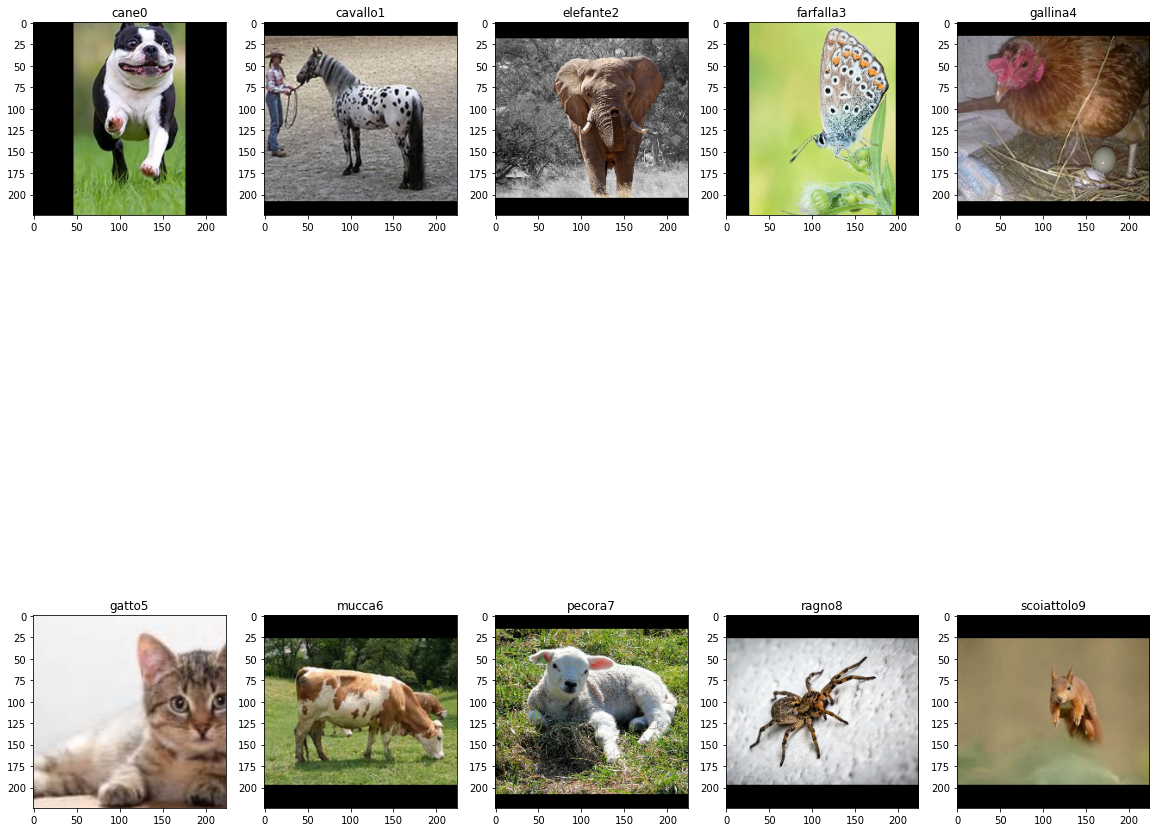

In [24]:
rows,cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[2]
#     image = cv2.imread(path[0])/
    axes[i//cols, i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [25]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
# 打乱标签
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

img_rows, img_cols, img_channel = 224, 224, 3
name_animal = []
# 将意大利语标签转化为英文
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'scoiattolo':
        name_animal.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        name_animal.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        name_animal.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        name_animal.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        name_animal.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        name_animal.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        name_animal.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        name_animal.append('dog')

x_train (800, 224, 224, 3)
y_train (800,)
x_test (200, 224, 224, 3)
y_test (200,)


In [26]:
# 导入深度学习模型VGG16
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))


add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
# 多分类问题
add_model.add(Dense(10, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [28]:
# 超参数
batch_size = 16
epochs = 50

# 对数据进行增强，增强模型的泛化能力
train_datagen = ImageDataGenerator(
        #旋转范围
        rotation_range=30,
        # 水平平移范围
        width_shift_range=0.1,
        # 垂直平移范围
        height_shift_range=0.1,
        # 水平反转
        horizontal_flip=True)
# 将生成器用于训练数据,
train_datagen.fit(x_train)


history = model.fit_generator(
    # 按batch_size大小从x,y生成增强数据
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')]
)

Epoch 1/50
50/50 [==============================] - 29s 580ms/step - loss: 0.3455 - accuracy: 0.9000 - val_loss: 0.3334 - val_accuracy: 0.9000
Epoch 2/50
50/50 [==============================] - 24s 478ms/step - loss: 0.3278 - accuracy: 0.9000 - val_loss: 0.3255 - val_accuracy: 0.9000
Epoch 3/50
50/50 [==============================] - 24s 478ms/step - loss: 0.3229 - accuracy: 0.9000 - val_loss: 0.3189 - val_accuracy: 0.9000
Epoch 4/50
50/50 [==============================] - 24s 478ms/step - loss: 0.3158 - accuracy: 0.9000 - val_loss: 0.3149 - val_accuracy: 0.9000
Epoch 5/50
50/50 [==============================] - 24s 478ms/step - loss: 0.3107 - accuracy: 0.9000 - val_loss: 0.3091 - val_accuracy: 0.9000
Epoch 6/50
50/50 [==============================] - 24s 478ms/step - loss: 0.3058 - accuracy: 0.9000 - val_loss: 0.3039 - val_accuracy: 0.9000
Epoch 7/50
50/50 [==============================] - 24s 479ms/step - loss: 0.2994 - accuracy: 0.9000 - val_loss: 0.2966 - val_accuracy: 0.9000

CNN: Epochs=50, Train accuracy=0.98900, Validation accuracy=0.95800


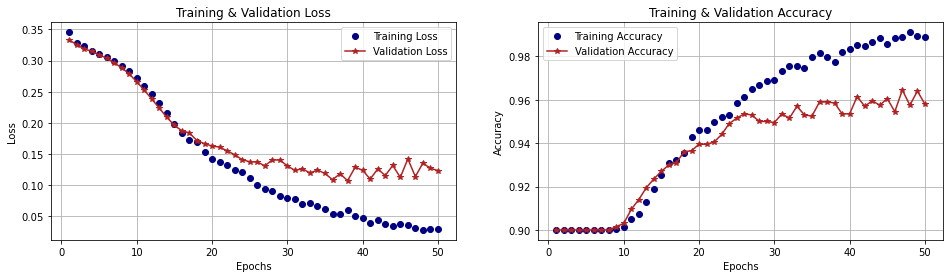

In [29]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # 将训练和验证集每一轮的损失值画出来
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # 将训练和验证集每一轮的准确度画出来
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)

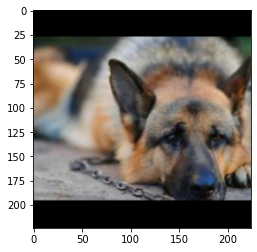

Actual  : dog
Predict : dog


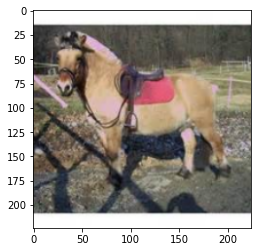

Actual  : horse
Predict : horse


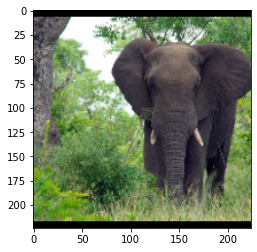

Actual  : elephant
Predict : sheep


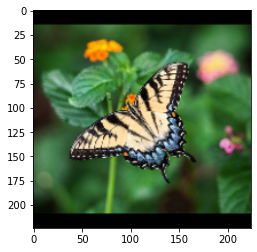

Actual  : butterfly
Predict : butterfly


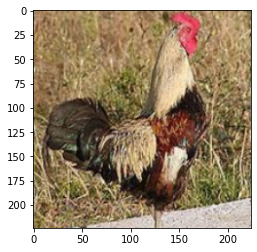

Actual  : chicken
Predict : chicken


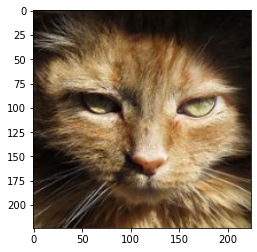

Actual  : cat
Predict : cat


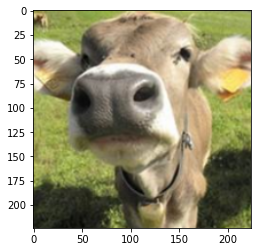

Actual  : cow
Predict : dog


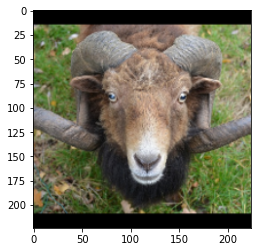

Actual  : sheep
Predict : cow


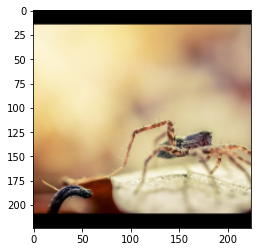

Actual  : spider
Predict : spider


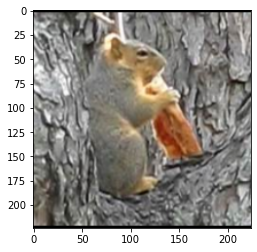

Actual  : squirrel
Predict : squirrel


In [30]:
test_images = []
# j为每个测试目录里面的数据下标index
j = 39 
for i in range(10):
    # 获取每个目录路径
    path = train_df[train_df.category == i].values[j]
    # 获取路径中的一张图片
    a = images[train_df[train_df.filename == path[0]].index[0]]
    img = np.array(a)
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = centering_image(cv2.resize(img, dsize=tile_size))
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,224,224,3)
# 使用模型进行训练
something = model.predict(test_images)
animals = name_animal
i = 0
for pred in something:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    i += 1
